# Demo VirtualHome Simulator

## Initialize Unity communication

In [1]:
import json
import IPython.display
import PIL
import numpy as np
import os
os.chdir('../simulation/')
from unity_simulator.comm_unity import UnityCommunication
comm = UnityCommunication()

## Scene start

In [2]:
comm.reset()

True

## Display the scene

This scene has 90 cameras


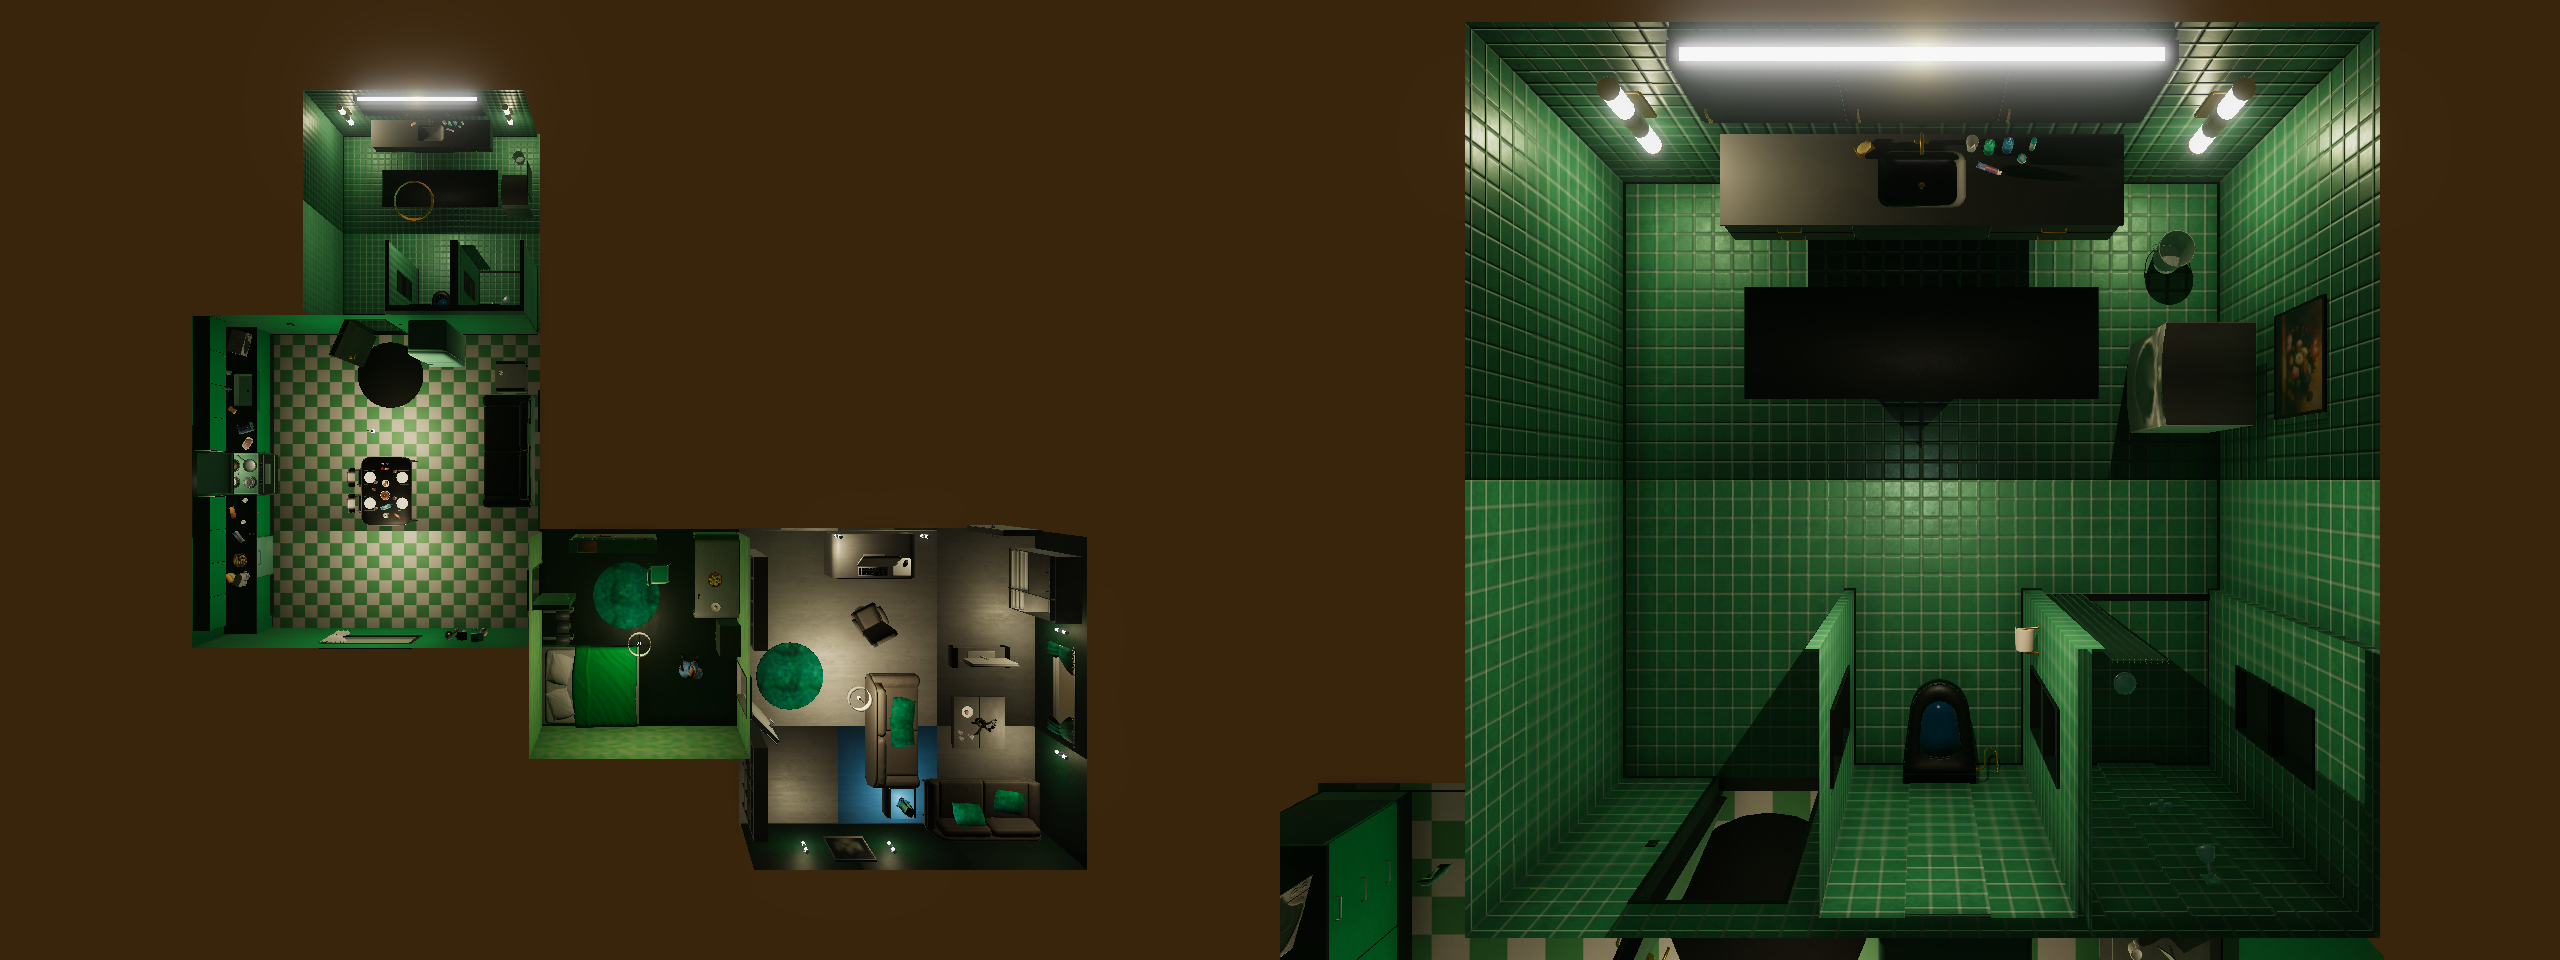

In [3]:
_, ncameras = comm.camera_count()
print('This scene has {} cameras'.format(ncameras))
cameras_select = list(range(ncameras))
ids = [-7, -10]
cameras_select = [cameras_select[x] for x in ids]

(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal', image_width=1280, image_height=960)
img_final = np.concatenate(imgs, 1)
IPython.display.display(PIL.Image.fromarray(img_final[:,:,::-1]), )

## Switch to new scene and display

There are 79 cameras


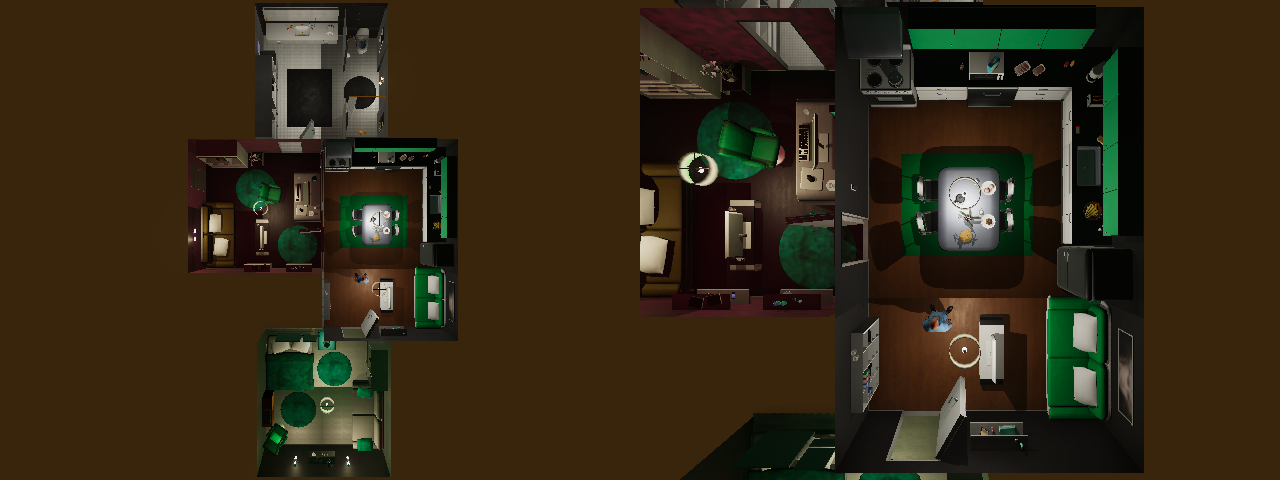

In [4]:
# Rooms 0 to 6
comm.reset(4)
_, ncameras = comm.camera_count()
print('There are {} cameras'.format(ncameras))
cameras_select = list(range(ncameras))
ids = [-7, -10]
cameras_select = [cameras_select[x] for x in ids]
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
img_final = np.concatenate(imgs, 1)
IPython.display.display(PIL.Image.fromarray(img_final[:,:,::-1]))

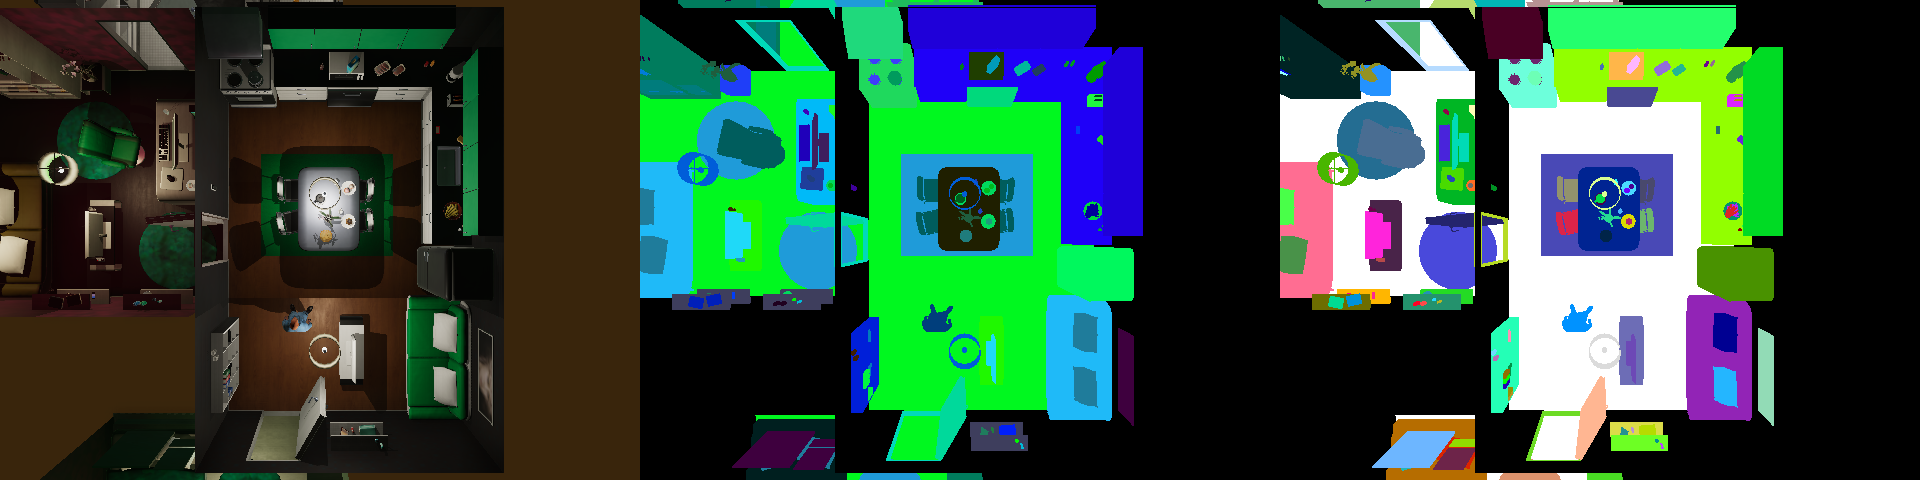

In [5]:
ids = [-10]
cameras_select = list(range(ncameras))
cameras_select = [cameras_select[x] for x in ids]
imgs_modality = []
modes = ['normal', 'seg_class', 'seg_inst']
for mode_name in modes:
    (ok_img, imgs) = comm.camera_image(cameras_select, mode=mode_name)
    img_curr = imgs[-1]
    if mode_name == 'flow':
        print(img_curr.shape)
        
    imgs_modality.append(img_curr)
img_final = np.concatenate(imgs_modality, 1)
IPython.display.display(PIL.Image.fromarray(img_final[:,:,::-1]))

## Obtain the current graph

In [6]:
success, graph = comm.environment_graph()

In [7]:
print('Example node')
print(graph['nodes'][0])
print(graph['nodes'][17])
print('')
print('Example edge')
print(graph['edges'][15])

Example node
{'id': 1, 'category': 'Rooms', 'class_name': 'livingroom', 'prefab_name': 'PRE_ROO_Livingroom_07', 'bounding_box': {'center': [-0.0313837528, 1.24901164, -1.24998593], 'size': [5.062842, 2.50202322, 5.00004625]}, 'properties': [], 'states': []}
{'id': 18, 'category': 'Furniture', 'class_name': 'desk', 'prefab_name': 'PRE_FUR_CPU_table_01_02', 'bounding_box': {'center': [1.893, 0.475000024, -0.7], 'size': [1.06799066, 0.950000048, 2.02800512]}, 'properties': ['SURFACES'], 'states': []}

Example edge
{'from_id': 17, 'to_id': 1, 'relation_type': 'INSIDE'}


#### Define some functions for manipulating the environment graph

In [8]:
def find_nodes(graph, **kwargs):
    if len(kwargs) == 0:
        return None
    else:
        k, v = next(iter(kwargs.items()))
        return [n for n in graph['nodes'] if n[k] == v]
    
def find_edges_from(graph, id):
    nb_list = [(e['relation_type'], e['to_id']) for e in graph['edges'] if e['from_id'] == id]
    return [(rel, find_nodes(graph, id=n_id)[0]) for (rel, n_id) in nb_list]

def clean_graph(graph):
    """
    Remove bounds to reflect real input by Andrew & Xavier
    """
    new_nodes = []
    for n in graph['nodes']:
        nc = dict(n)
        if 'bounding_box' in nc:
            del nc['bounding_box']
        new_nodes.append(nc)
    return {'nodes': new_nodes, 'edges': list(graph['edges'])}
    

def remove_edges(graph, n, fr=True, to=True):
    n_id = n['id']
    new_edges = [e for e in graph['edges'] if 
                 (e['from_id'] != n_id or not fr) and (e['to_id'] != n_id or not to)]
    graph['edges'] = new_edges

def remove_edge(graph, fr_id, rel, to_id):
    new_edges = [e for e in graph['edges'] if 
                 not (e['from_id'] == fr_id and e['to_id'] == to_id and e['relation_type'] == rel)]
    graph['edges'] = new_edges
    
def add_node(graph, n):
    graph['nodes'].append(n)

def add_edge(graph, fr_id, rel, to_id):
    graph['edges'].append({'from_id': fr_id, 'relation_type': rel, 'to_id': to_id})
    
def clean_graph(graph):
    """
    Remove bounds to reflect real input by Andrew & Xavier
    """
    new_nodes = []
    for n in graph['nodes']:
        nc = dict(n)
        if 'bounding_box' in nc:
            del nc['bounding_box']
        new_nodes.append(nc)
    return {'nodes': new_nodes, 'edges': list(graph['edges'])}



In [9]:
def add_cat(graph):
    graph_1 = clean_graph(graph)
    sofa = find_nodes(graph_1, class_name='sofa')[-2]
    print(sofa)
    add_node(graph_1, {'class_name': 'cat', 'category': 'Animals', 'id': 1000, 'properties': [], 'states': []})
    add_edge(graph_1, 1000, 'ON', sofa['id'])
    return graph_1

In [10]:
def add_beer(graph):
    graph_1 = clean_graph(graph)
    sofa = find_nodes(graph_1, class_name='fridge')[-1]
    print(sofa)
    add_node(graph_1, {'class_name': 'beer', 'id': 1001, 'properties': [], 'states': []})
    add_edge(graph_1, 1001, 'INSIDE', sofa['id'])
    return graph_1

## Add cat to the scene

{'id': 131, 'category': 'Furniture', 'class_name': 'sofa', 'prefab_name': 'PRE_FUR_Sofa_02_03_02_01', 'properties': ['SITTABLE', 'LIEABLE'], 'states': []}


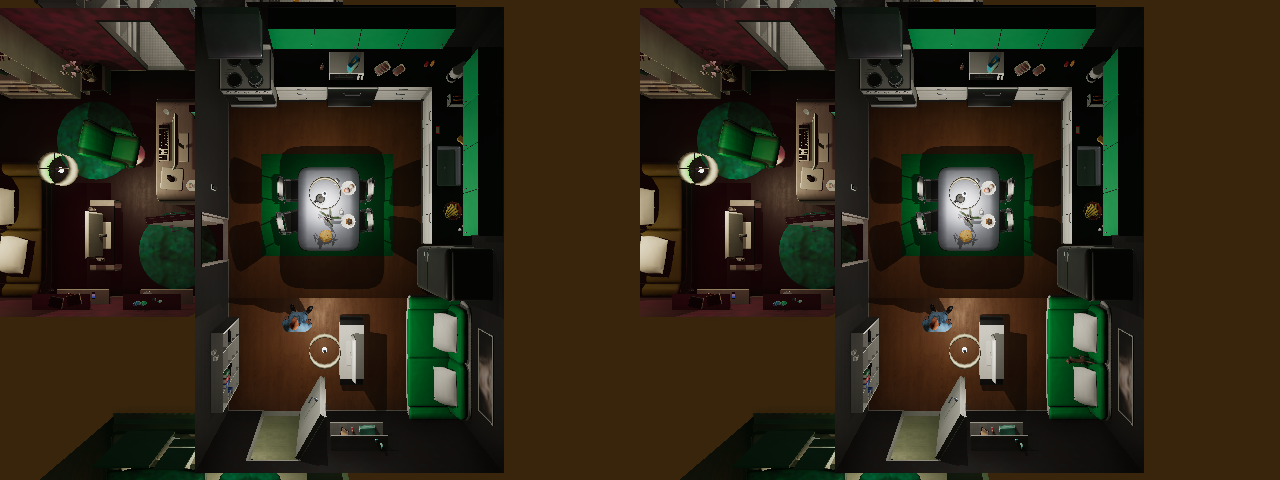

In [11]:
comm.reset()
success, graph = comm.environment_graph();
graph_1 = add_cat(graph)
(ok_img, imgs_prev) = comm.camera_image(cameras_select, mode='normal')
success, message = comm.expand_scene(graph_1)
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
img_final = np.concatenate([imgs_prev[-1], imgs[-1]], 1)
IPython.display.display(PIL.Image.fromarray(img_final[:,:,::-1]))

# Generating Scripts

In [12]:
comm.reset(3)
success, graph = comm.environment_graph()
graph_1 = add_beer(graph)
success, message = comm.expand_scene(graph_1)
print(message)

{'id': 80, 'category': 'Appliances', 'class_name': 'fridge', 'prefab_name': 'PRE_APP_Fridge_01_02', 'properties': ['CAN_OPEN', 'CONTAINERS', 'HAS_PLUG'], 'states': ['CLOSED']}
{}


In [13]:
script = ['[Walk] <fridge> (80)', '[Open] <fridge> (80)','[Find] <beer> (1001)', 
          '[Grab] <beer> (1001)', '[Close] <fridge> (80)', 
          '[Walk] <tv> (278)', '[SwitchOn] <tv> (278)',
          '[Walk] <sofa> (257)', '[Sit] <sofa> (257)', '[Watch] <tv> (278)']
success, message = comm.render_script(script=script, 
                                      capture_screenshot=True, 
                                      find_solution=False,
                                      frame_rate=20,
                                      output_folder='auto',
                                      image_width=1024, image_height=640,
                                      camera_mode='FIRST_PERSON')

UnityEngineException: (408, {'id': '1555473283.731507', 'success': False, 'message': 'Timeout', 'value': 0, 'message_list': None})

List of action
- Open
- Close
- SwitchOn
- SwitchOff
- PutBack
- PutIn
- Drink
- Talk
- Text
- Grab
- Sit
- StandUp
- Walk
- Run
- TurnTo
- PointAt
- LookAt
- Find
- Touch

Paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [14]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
script = ['[Walk] <cat> (1)', '[Grab] <cat> (1)']
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=True, 
                                      camera_mode='PERSON_TOP')

{'id': 256, 'category': 'Furniture', 'class_name': 'sofa', 'prefab_name': 'PRE_FUR_Sofa_02_02_01_03', 'properties': ['SITTABLE', 'LIEABLE'], 'states': []}


In [ ]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
script = ['[Walk] <cat> (1)', '[Grab] <cat> (1)']
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=True, 
                                      camera_mode='FIRST_PERSON')

In [15]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
id_cat = [x for x in graph_1['nodes'] if x['class_name'] == 'cat'][0]['id']
id_table = [x for x in graph_1['nodes'] if x['class_name'] == 'kitchentable'][0]['id']


{'id': 256, 'category': 'Furniture', 'class_name': 'sofa', 'prefab_name': 'PRE_FUR_Sofa_02_02_01_03', 'properties': ['SITTABLE', 'LIEABLE'], 'states': []}


In [ ]:

script = ['[Walk] <cat> ({})'.format(id_cat), 
          '[Grab] <cat> ({})'.format(id_cat),
          '[Walk] <kitchentable> ({})'.format(id_table),
          '[PutBack] <cat> ({}) <kitchentable> ({})'.format(id_cat, id_table)]
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=False, 
                                      camera_mode='PERSON_TOP')

### Examples - tested  to work on scene 7!

#### Grab mug, go to toilet, sit on toilet, open fridge

In [ ]:
comm.reset()
success, graph = comm.environment_graph()

In [ ]:
mug_id = find_nodes(graph, class_name='mug')[0]['id']
toilet_id = find_nodes(graph, class_name='toilet')[0]['id']
fridge_id = find_nodes(graph, class_name='fridge')[0]['id']

Use ids from environment graph, do not let Unity to find a solution

In [ ]:
script = ['[Walk] <mug> ({})'.format(mug_id), 
          '[Grab] <mug> ({})'.format(mug_id),
          '[Walk] <toilet> ({})'.format(toilet_id),
          '[Sit] <toilet> ({})'.format(toilet_id),
          '[Walk] <fridge> ({})'.format(fridge_id),
          '[Open] <fridge> ({})'.format(fridge_id)]          
success, message = comm.render_script(script=script, capture_screenshot=True, find_solution=False, camera_mode='PERSON_FRONT')

#### Put tv on table (prepare scene only, no rendering)

In [ ]:
comm.reset()
success, graph = comm.environment_graph()

In [ ]:
graph_1 = clean_graph(graph)
table = find_nodes(graph_1, class_name='kitchentable')[0]
new_node = {'class_name': 'tv', 'category': 'Electronics', 'id': 1000, 
            'properties': ['HAS_SWITCH', 'LOOKABLE', 'HAS_PLUG'], 'states': ['OFF']}
add_node(graph_1, new_node)
add_edge(graph_1, 1000, 'ON', table['id'])

In [ ]:
success, message = comm.expand_scene(graph_1, ignore_placing_obstacles=True)

Note new option __ignore_placing_obstacles__ which allows an object to be put even if it collides with other object on the destination

#### Put a lamp on a table, turn it on, turn other lights off (scene preparation example)

In [ ]:
comm.reset()
success, graph = comm.environment_graph()

Put a lamp to kitchen table with initial state set to "off"

In [ ]:
graph_1 = clean_graph(graph)

table = find_nodes(graph_1, class_name='kitchentable')[0]
new_node = {'class_name': 'tablelamp', 'category': 'Lamps', 'id': 1000, 
            'properties': ['HAS_SWITCH'], 'states': ['OFF']}
add_node(graph_1, new_node)
add_edge(graph_1, 1000, 'ON', table['id'])
success, message = comm.expand_scene(graph_1, ignore_placing_obstacles=True)

Turn off all lights

In [ ]:
graph_2 = clean_graph(graph_1)
lsws = find_nodes(graph_2, class_name='lightswitch')
for ls in lsws:
    ls['states'] =  ['OFF']
success, message = comm.expand_scene(graph_2)

Turn on the lamp

In [ ]:
graph_3 = clean_graph(graph_2)
tlamps = find_nodes(graph_3, id=1000)
for ls in tlamps:
    ls['states'] =  ['ON']
success, message = comm.expand_scene(graph_3)